# Finetune ResNet50


With 1000 x 400 repetitively-padded melspectrogram images without data augmentation


In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import time

In [2]:
# Get the absolute path to the project root without relying on __file__
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, "../.."))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
True


Set the seed for reproducability


In [4]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

if (torch.cuda.is_available()):
    torch.cuda.manual_seed(random_seed)

Set some constant strings


In [5]:
FINETUNED_MODEL = 'resnet50_repetitive'

train_csv = '../../../data/melspectrogram_train_dataset.csv'
test_csv = '../../../data/melspectrogram_test_dataset.csv'
val_csv = '../../../data/melspectrogram_val_dataset.csv'
root_dir = '../../../data/'
class_weights_path = '../../../data/class_weights.pt'

Custom dataset class for loading the mel spectrogram images


In [6]:
from datasets.MelspectrogramDataset import MelSpectrogramDataset

Define the training function


In [7]:
def train(model, trainloader, criterion, optimizer, device):
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    # train mode
    model.train()

    epoch_start = time.time()
    pbar = tqdm(enumerate(trainloader), total=len(
        trainloader), desc="Training")

    for i, (inputs, labels) in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update training loss
        train_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # Calculate time metrics
        elapsed = time.time() - epoch_start
        progress = (i + 1) / len(trainloader)
        eta = elapsed / progress - elapsed

        # Update progress bar with current loss and ETA
        pbar.set_postfix({
            "Loss": f"{loss.item()}",
            "Elapsed": f"{elapsed:.4f}s",
            "ETA": f"{eta:.4f}s"
        })

    train_loss = train_loss / len(trainloader)
    train_accuracy = train_correct / train_total * 100

    return model, train_loss, train_accuracy

Define the validation function


In [8]:
def validate(model, valloader, criterion, device):
    val_loss = 0.0
    val_total = 0
    val_correct = 0

    # Switch to evaluation mode
    model.eval()

    epoch_start = time.time()
    pbar = tqdm(enumerate(valloader), total=len(
        valloader), desc="Validating")

    with torch.no_grad():
        for i, (inputs, labels) in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update test loss
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            # Calculate time metrics
            elapsed = time.time() - epoch_start
            progress = (i + 1) / len(valloader)
            eta = elapsed / progress - elapsed

            # Update progress bar with current loss and ETA
            pbar.set_postfix({
                "Loss": f"{loss.item()}",
                "Elapsed": f"{elapsed:.4f}s",
                "ETA": f"{eta:.4f}s"
            })

    val_loss = val_loss / len(valloader)
    val_accuracy = val_correct / val_total * 100

    return val_loss, val_accuracy

Define what happens in each epoch


In [9]:
def train_epochs(model, trainloader, valloader, criterion, optimizer, device, num_epochs):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_accuracy = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        epoch_start = time.time()

        model, train_loss, train_accuracy = train(
            model, trainloader, criterion, optimizer, device)
        val_loss, val_accuracy = validate(
            model, valloader, criterion, device)

        epoch_elapsed = time.time() - epoch_start
        print(f"Epoch {epoch+1} completed in {epoch_elapsed:.4f}s")
        print(f'Train Loss: {train_loss} - Train Accuracy: {train_accuracy}')
        print(
            f'Validation Loss: {val_loss} - Validation Accuracy: {val_accuracy}')
        print()

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Check if current model is best performing using test_accuracy
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), f'best_{FINETUNED_MODEL}.pt')
            checkpoint = {
                'epoch': epoch + 1,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'val_losses': val_losses,
                'val_accuracies': val_accuracies,
            }
            torch.save(checkpoint, f'best_{FINETUNED_MODEL}_checkpoint.pt')

    return model, train_losses, train_accuracies, val_losses, val_accuracies

Plot the loss and accuracy graphs


In [10]:
def plot_loss(train_losses, val_losses):
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [11]:
def plot_accuracy(train_accuracies, val_accuracies):
    plt.figure()
    plt.plot(range(len(train_accuracies)),
             train_accuracies, label='Training Accuracy')
    plt.plot(range(len(val_accuracies)),
             val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Define the model


In [12]:
model = models.resnet50(pretrained=True)

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Prepare for fine-tuning


In [13]:
# Number of classes
num_classes = 9

# Freeze all layers except the last fully connected layer
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Modify final fully connected layer according to number of classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)
# print("Modified model")
# print(model)

# Unfreeze the final fully connected layer so it will be trained
for param in model.fc.parameters():
    param.requires_grad = True

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Define the learning rate, criterion, optimizer, transformations, and number of epochs


In [14]:
learning_rate = 0.001

class_weights = torch.load(class_weights_path).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define transformations
transform = transforms.Compose([
    # Resize the Mel spectrogram to 224x224, suitable for ResNet50
    transforms.Resize((224, 224)),
    transforms.ToTensor(),          # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                         0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])

epochs = 20

C:\Users\profi\AppData\Local\Temp\ipykernel_11612\3411069088.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  class_weights = torch.load(class_weights_path).to(device)


Execute the fine-tuning


Mapping from Emotion to Number: {'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}
Model is on: cuda:0
Epoch 1/20


Validating: 100%|██████████| 75/75 [00:16<00:00,  4.56it/s, Loss=0.8594529628753662, Elapsed=29.8655s, ETA=0.0000s]  


Epoch 1 completed in 109.8117s
Train Loss: 1.424632873493812 - Train Accuracy: 42.868772755025894
Validation Loss: 1.2930340401331584 - Validation Accuracy: 46.08484592655129

Epoch 2/20


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.61it/s, Loss=0.926964282989502, Elapsed=23.6140s, ETA=0.0000s]   


Epoch 2 completed in 79.6241s
Train Loss: 1.2590290289049204 - Train Accuracy: 48.11062617308519
Validation Loss: 1.2626510175069172 - Validation Accuracy: 48.25875897002955

Epoch 3/20


Validating: 100%|██████████| 75/75 [00:10<00:00,  7.31it/s, Loss=0.7780669927597046, Elapsed=23.8188s, ETA=0.0000s]  


Epoch 3 completed in 79.2090s
Train Loss: 1.2073682284768605 - Train Accuracy: 49.85640306641641
Validation Loss: 1.2608501847585043 - Validation Accuracy: 47.09793161671592

Epoch 4/20


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.53it/s, Loss=0.7780094146728516, Elapsed=23.4593s, ETA=0.0000s]  


Epoch 4 completed in 78.9127s
Train Loss: 1.1798800817459305 - Train Accuracy: 50.808439429230454
Validation Loss: 1.1903249144554138 - Validation Accuracy: 49.841705360911774

Epoch 5/20


Validating: 100%|██████████| 75/75 [00:10<00:00,  7.47it/s, Loss=0.6565465331077576, Elapsed=23.8470s, ETA=0.0000s]  


Epoch 5 completed in 79.8290s
Train Loss: 1.1590389686857345 - Train Accuracy: 51.156690260283575
Validation Loss: 1.2118180561065675 - Validation Accuracy: 49.5040101308569

Epoch 6/20


Validating: 100%|██████████| 75/75 [00:10<00:00,  7.39it/s, Loss=0.811223566532135, Elapsed=23.7599s, ETA=0.0000s]   


Epoch 6 completed in 79.6604s
Train Loss: 1.1418956847204638 - Train Accuracy: 52.002442278555435
Validation Loss: 1.171773718992869 - Validation Accuracy: 51.97340650063318

Epoch 7/20


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.52it/s, Loss=0.5401841402053833, Elapsed=23.8795s, ETA=0.0000s]  


Epoch 7 completed in 79.8107s
Train Loss: 1.1282415514047435 - Train Accuracy: 52.59039822708667
Validation Loss: 1.20186505317688 - Validation Accuracy: 50.52764879696075

Epoch 8/20


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.54it/s, Loss=0.42192739248275757, Elapsed=22.4070s, ETA=0.0000s] 


Epoch 8 completed in 76.7026s
Train Loss: 1.118792397610714 - Train Accuracy: 52.936387689106986
Validation Loss: 1.2251514887809754 - Validation Accuracy: 47.899957788096245

Epoch 9/20


Validating: 100%|██████████| 75/75 [00:10<00:00,  7.39it/s, Loss=0.5503734946250916, Elapsed=23.5010s, ETA=0.0000s]  


Epoch 9 completed in 77.9041s
Train Loss: 1.1050487115893062 - Train Accuracy: 53.41353655503042
Validation Loss: 1.140364138285319 - Validation Accuracy: 50.137188687209786

Epoch 10/20


Validating: 100%|██████████| 75/75 [00:10<00:00,  7.20it/s, Loss=0.4642033278942108, Elapsed=23.6278s, ETA=0.0000s]  


Epoch 10 completed in 79.7757s
Train Loss: 1.096262804690124 - Train Accuracy: 53.705253160263226
Validation Loss: 1.1322914508978525 - Validation Accuracy: 51.329674968341074

Epoch 11/20


Validating: 100%|██████████| 75/75 [00:10<00:00,  7.27it/s, Loss=0.4631792902946472, Elapsed=23.2469s, ETA=0.0000s]  


Epoch 11 completed in 78.9022s
Train Loss: 1.0831976226299485 - Train Accuracy: 54.162049704891345
Validation Loss: 1.2296364514033 - Validation Accuracy: 48.87083157450401

Epoch 12/20


Validating: 100%|██████████| 75/75 [00:10<00:00,  7.45it/s, Loss=0.7321263551712036, Elapsed=23.1728s, ETA=0.0000s]  


Epoch 12 completed in 78.4433s
Train Loss: 1.074409644038691 - Train Accuracy: 54.42436851269758
Validation Loss: 1.1179162430763245 - Validation Accuracy: 54.72773322076826

Epoch 13/20


Validating: 100%|██████████| 75/75 [00:10<00:00,  7.44it/s, Loss=0.503358006477356, Elapsed=22.9909s, ETA=0.0000s]   


Epoch 13 completed in 78.3150s
Train Loss: 1.0651509344922325 - Train Accuracy: 54.49673232174759
Validation Loss: 1.1570417785644531 - Validation Accuracy: 51.02363866610384

Epoch 14/20


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.57it/s, Loss=0.41787227988243103, Elapsed=21.2685s, ETA=0.0000s]


Epoch 14 completed in 74.5904s
Train Loss: 1.067642823981412 - Train Accuracy: 54.763573867619456
Validation Loss: 1.1195306742191315 - Validation Accuracy: 52.96538623891938

Epoch 15/20


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.71it/s, Loss=0.48523640632629395, Elapsed=21.3828s, ETA=0.0000s] 


Epoch 15 completed in 74.5521s
Train Loss: 1.0489957832187586 - Train Accuracy: 55.3696207684132
Validation Loss: 1.1152280028661092 - Validation Accuracy: 53.63022372308991

Epoch 16/20


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.66it/s, Loss=0.47890353202819824, Elapsed=21.3822s, ETA=0.0000s] 


Epoch 16 completed in 74.5244s
Train Loss: 1.0489868687067418 - Train Accuracy: 55.258813685805386
Validation Loss: 1.1188510179519653 - Validation Accuracy: 54.85436893203883

Epoch 17/20


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.80it/s, Loss=0.6633933186531067, Elapsed=21.4213s, ETA=0.0000s]  


Epoch 17 completed in 75.0079s
Train Loss: 1.037907218829745 - Train Accuracy: 55.95531534791163
Validation Loss: 1.0982069563865662 - Validation Accuracy: 54.495567750105536

Epoch 18/20


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.66it/s, Loss=0.5445206165313721, Elapsed=21.3031s, ETA=0.0000s]  


Epoch 18 completed in 74.5192s
Train Loss: 1.0260957615568458 - Train Accuracy: 56.21311141765225
Validation Loss: 1.0921144874890645 - Validation Accuracy: 55.5403123680878

Epoch 19/20


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.67it/s, Loss=0.6135098934173584, Elapsed=21.2444s, ETA=0.0000s] 


Epoch 19 completed in 74.0582s
Train Loss: 1.023204863588245 - Train Accuracy: 56.204065941520994
Validation Loss: 1.143275225162506 - Validation Accuracy: 55.31869987336429

Epoch 20/20


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.71it/s, Loss=0.7599602341651917, Elapsed=21.2003s, ETA=0.0000s]  

Epoch 20 completed in 74.4280s
Train Loss: 1.0232935294595067 - Train Accuracy: 56.081952013749124
Validation Loss: 1.106228772799174 - Validation Accuracy: 55.33980582524271



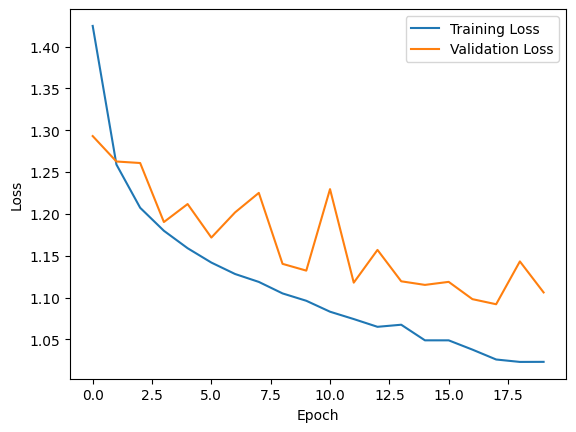

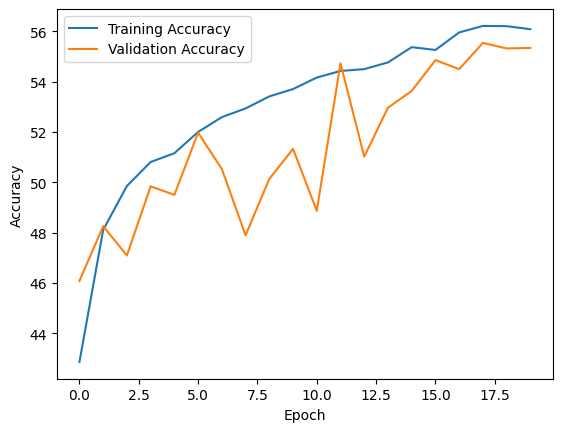

In [15]:
trainset = MelSpectrogramDataset(
    csv_file=train_csv, root_dir=root_dir, transform=transform)
valset = MelSpectrogramDataset(
    csv_file=val_csv, root_dir=root_dir, transform=transform)
testset = MelSpectrogramDataset(
    csv_file=test_csv, root_dir=root_dir, transform=transform)

trainloader = DataLoader(trainset, batch_size=128,
                         shuffle=True, num_workers=8, pin_memory=True)
valloader = DataLoader(valset, batch_size=128,
                       shuffle=False, num_workers=8, pin_memory=True)
testloader = DataLoader(testset, batch_size=128,
                        shuffle=False, num_workers=8, pin_memory=True)

# Label mappings
labelmap = trainset.label_map
print(f"Mapping from Emotion to Number: {labelmap}")

print(f"Model is on: {next(model.parameters()).device}")
model, train_losses, train_accuracies, val_losses, val_accuracies = train_epochs(
    model, trainloader, valloader, criterion, optimizer, device, epochs)
torch.save(model.state_dict(), f'{FINETUNED_MODEL}_variables_{epochs}.pt')

# Plots
plot_loss(train_losses, val_losses)
plot_accuracy(train_accuracies, val_accuracies)

Define the function to plot the confusion matrix


In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create figure and axes
    plt.figure(figsize=(10, 8))

    # Create heatmap
    sns.heatmap(cm,
                annot=True,  # Show numbers in cells
                fmt='d',     # Use integer formatting
                cmap='Blues',  # Color scheme
                xticklabels=trainset.label_map.keys(),
                yticklabels=trainset.label_map.keys())

    # Set labels and title
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')

    # Rotate axis labels for better readability
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)

    plt.tight_layout()
    plt.show()

Define the function to evaluate best model on test set


In [17]:
def get_predictions(model, testloader, device, model_path):
    # Load the best model weights
    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_preds = []
    all_labels = []
    print("Evaluating best model on test set...")

    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Store predictions for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

Define the function to print out the evaluation metrics


In [18]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report


def get_evaluation_metrics(true_labels, pred_labels, label_map):
    # Compute metrics
    accuracy = accuracy_score(true_labels, pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, pred_labels, average='weighted')

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-score: {f1:.4f}\n")

    # Print detailed classification report
    print(classification_report(true_labels, pred_labels,
          target_names=list(label_map.keys())))

Evaluate the best model on the test set


C:\Users\profi\AppData\Local\Temp\ipykernel_11612\3256607076.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Evaluating best model on test set...


Testing: 100%|██████████| 75/75 [00:28<00:00,  2.61it/s]


Test Accuracy: 0.5455
Test Precision: 0.5717
Test Recall: 0.5455
Test F1-score: 0.5381

              precision    recall  f1-score   support

       Anger       0.51      0.59      0.55       916
       Bored       0.67      0.82      0.74      1098
     Disgust       0.25      0.64      0.36       291
        Fear       0.34      0.56      0.42       308
       Happy       0.59      0.40      0.48      1914
     Neutral       0.62      0.34      0.44      2226
    Question       0.60      0.77      0.67      1139
         Sad       0.54      0.56      0.55       857
    Surprise       0.50      0.67      0.58       728

    accuracy                           0.55      9477
   macro avg       0.51      0.59      0.53      9477
weighted avg       0.57      0.55      0.54      9477



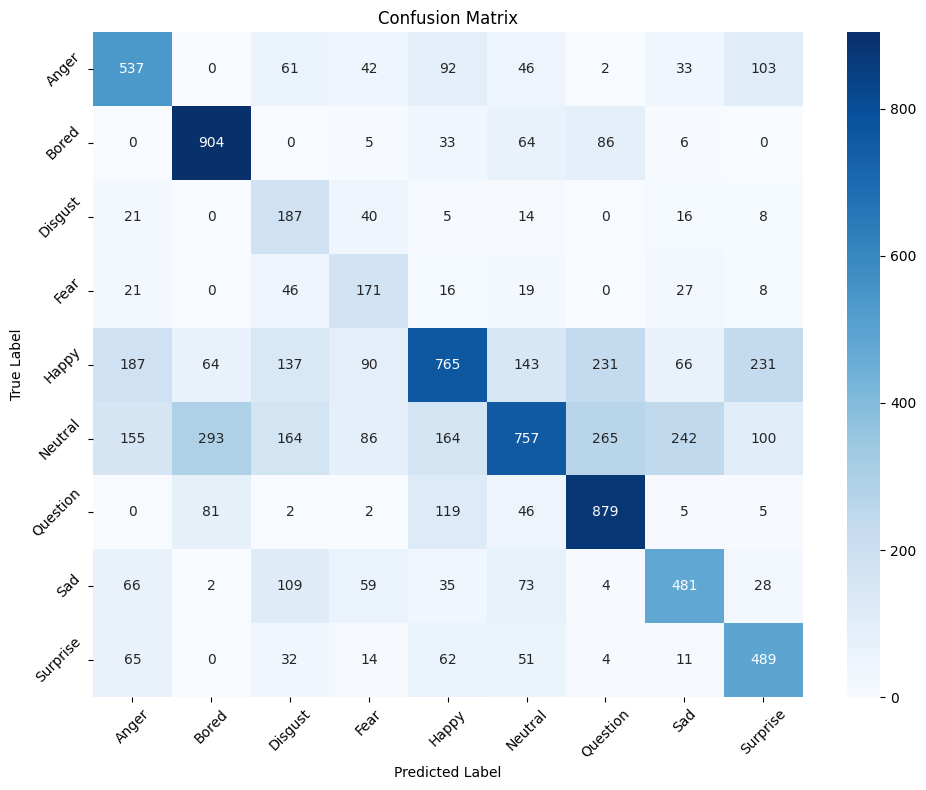

In [19]:
# Load and get predictions from the bets model
best_model_path = f'best_{FINETUNED_MODEL}.pt'
all_preds, all_labels = get_predictions(
    model=model,
    testloader=testloader,
    device=device,
    model_path=best_model_path
)

# Print detailed evaluation metrics
get_evaluation_metrics(all_labels, all_preds, labelmap)

# Plot confusion matrix
plot_confusion_matrix(all_labels, all_preds)